# Praca domowa 3 - Bartosz Rożek

Pracuję na zbiorze projektowym - ceny mieszkań w Kalifornii

In [2]:
setwd("/home/bartosz/Documents/studia/sem6/wb2/")

Wczytanie zbioru i jakiś preprocessing

In [3]:
housing <- read.csv("housing.csv")

housing$total_bedrooms[is.na(housing$total_bedrooms)] = median(housing$total_bedrooms , na.rm = TRUE)

housing$mean_bedrooms = housing$total_bedrooms/housing$households
housing$mean_rooms = housing$total_rooms/housing$households

drops = c('total_bedrooms', 'total_rooms')

housing = housing[ , !(names(housing) %in% drops)]
colnames(housing)

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "population"         "households"         "median_income"     
 [7] "median_house_value" "ocean_proximity"    "mean_bedrooms"     
[10] "mean_rooms"

In [4]:
set.seed(1738) # Set a random seed so that same sample can be reproduced in future runs

sample = sample.int(n = nrow(housing), size = floor(.8*nrow(housing)), replace = F)
train = housing[sample, ] #just the samples
test  = housing[-sample, ] #everything but the samples

In [5]:
train_y = train[,'median_house_value']
train_x = train[, names(train) !='median_house_value']

## Model 1 - random forest z kaggle

Używam modelu z kaggle - random forest

In [6]:
library('randomForest')
rf_model = randomForest(train_x, y = train_y , ntree = 500, importance = TRUE)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



In [148]:
library(DALEX)
library(DALEXtra)
explainer_rf <- DALEX::explain(model = rf_model,
                     data = test[,-7],
                     y = test$median_house_value)

Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  4128  rows  9  cols 
  -> target variable   :  4128  values 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  49646.46 , mean =  207761.7 , max =  499426.2  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -296358.5 , mean =  460.0371 , max =  334253.2  
  A new explainer has been created!  


In [150]:
fi_1 <- model_parts(explainer_rf, B = 10)

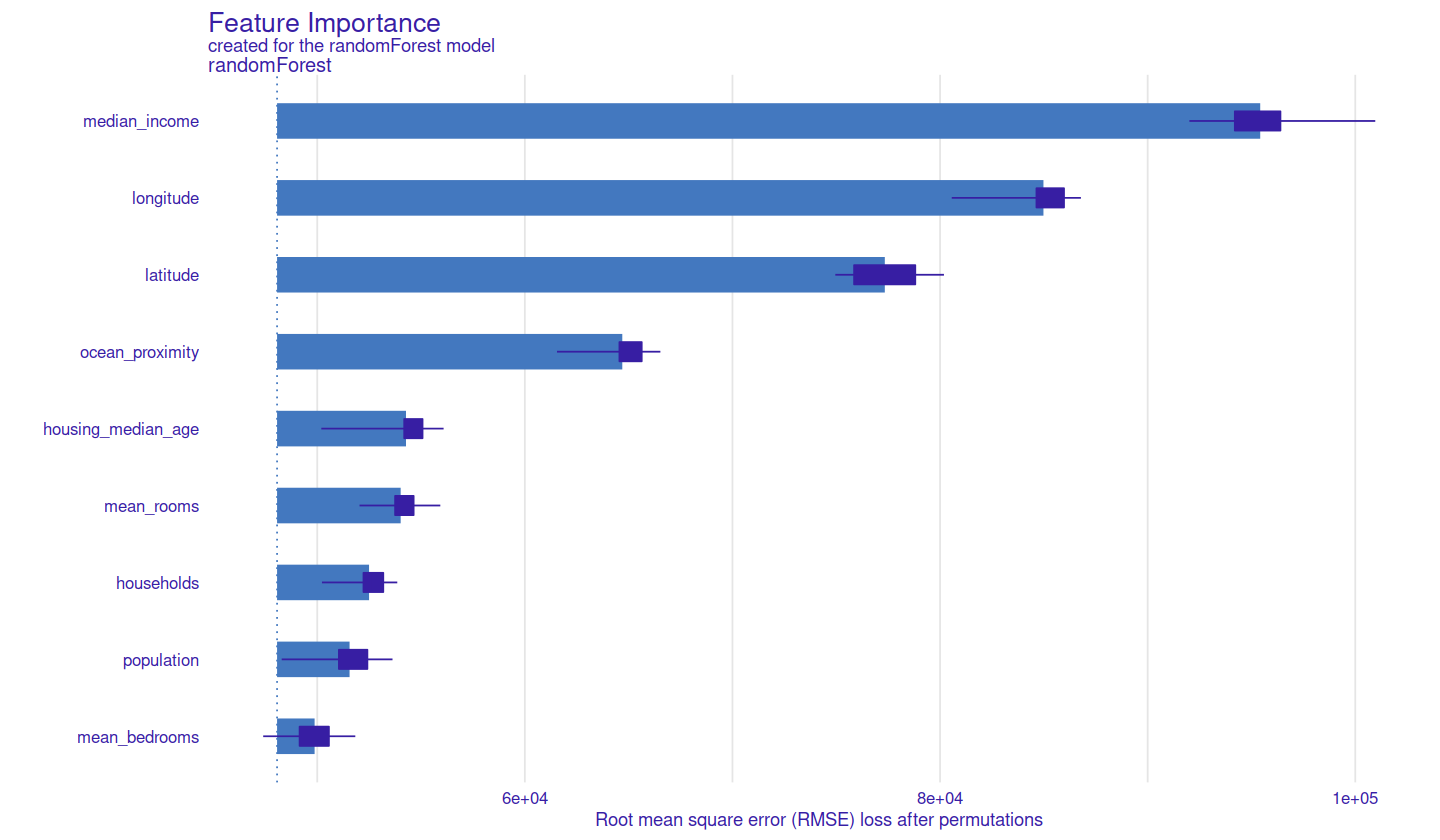

In [224]:
options(repr.plot.width=12, repr.plot.height=7)
plot(fi_1)

- najważniejsze są *median_income*, *longitude* i *latitude*
- warto pamietać, że *longitude* i *latitude* są mocno skorelowane, więc można przypuszczać, że one łącznie mogłyby być ważniejsze od *median_income*

## Model 2 - xGbosst

In [11]:
library(xgboost)
library(ggplot2)


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




In [12]:
dtrain <- xgb.DMatrix(data = data.matrix(train[,-7]), label = train$median_house_value)
dtest <- xgb.DMatrix(data = data.matrix(test[,-7]), label = test$median_house_value)

In [13]:
xg <- xgboost(data = dtrain, max.depth = 15, eta = 1, nthread = 10, nrounds = 10, objective = "reg:squarederror")

[1]	train-rmse:50753.156250 
[2]	train-rmse:29344.603516 
[3]	train-rmse:23046.810547 
[4]	train-rmse:19499.326172 
[5]	train-rmse:15683.132812 
[6]	train-rmse:12774.666016 
[7]	train-rmse:10639.395508 
[8]	train-rmse:9724.218750 
[9]	train-rmse:8705.917969 
[10]	train-rmse:7423.935547 


In [14]:
explainer_xg <- DALEX::explain(model = xg,
                     data = data.matrix(test[,-7]),
                     y = data.matrix(test[,7]))

Preparation of a new explainer is initiated
  -> model label       :  xgb.Booster  (  default  )
  -> data              :  4128  rows  9  cols 
  -> target variable   :  4128  values 
  -> predict function  :  yhat.xgb.Booster  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package xgboost , ver. 1.4.1.1 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  -79216.48 , mean =  207998.1 , max =  641735.3  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -344174.9 , mean =  223.5605 , max =  515742.6  
  A new explainer has been created!  


In [15]:
fi_2 <- model_parts(explainer_xg, B = 10)

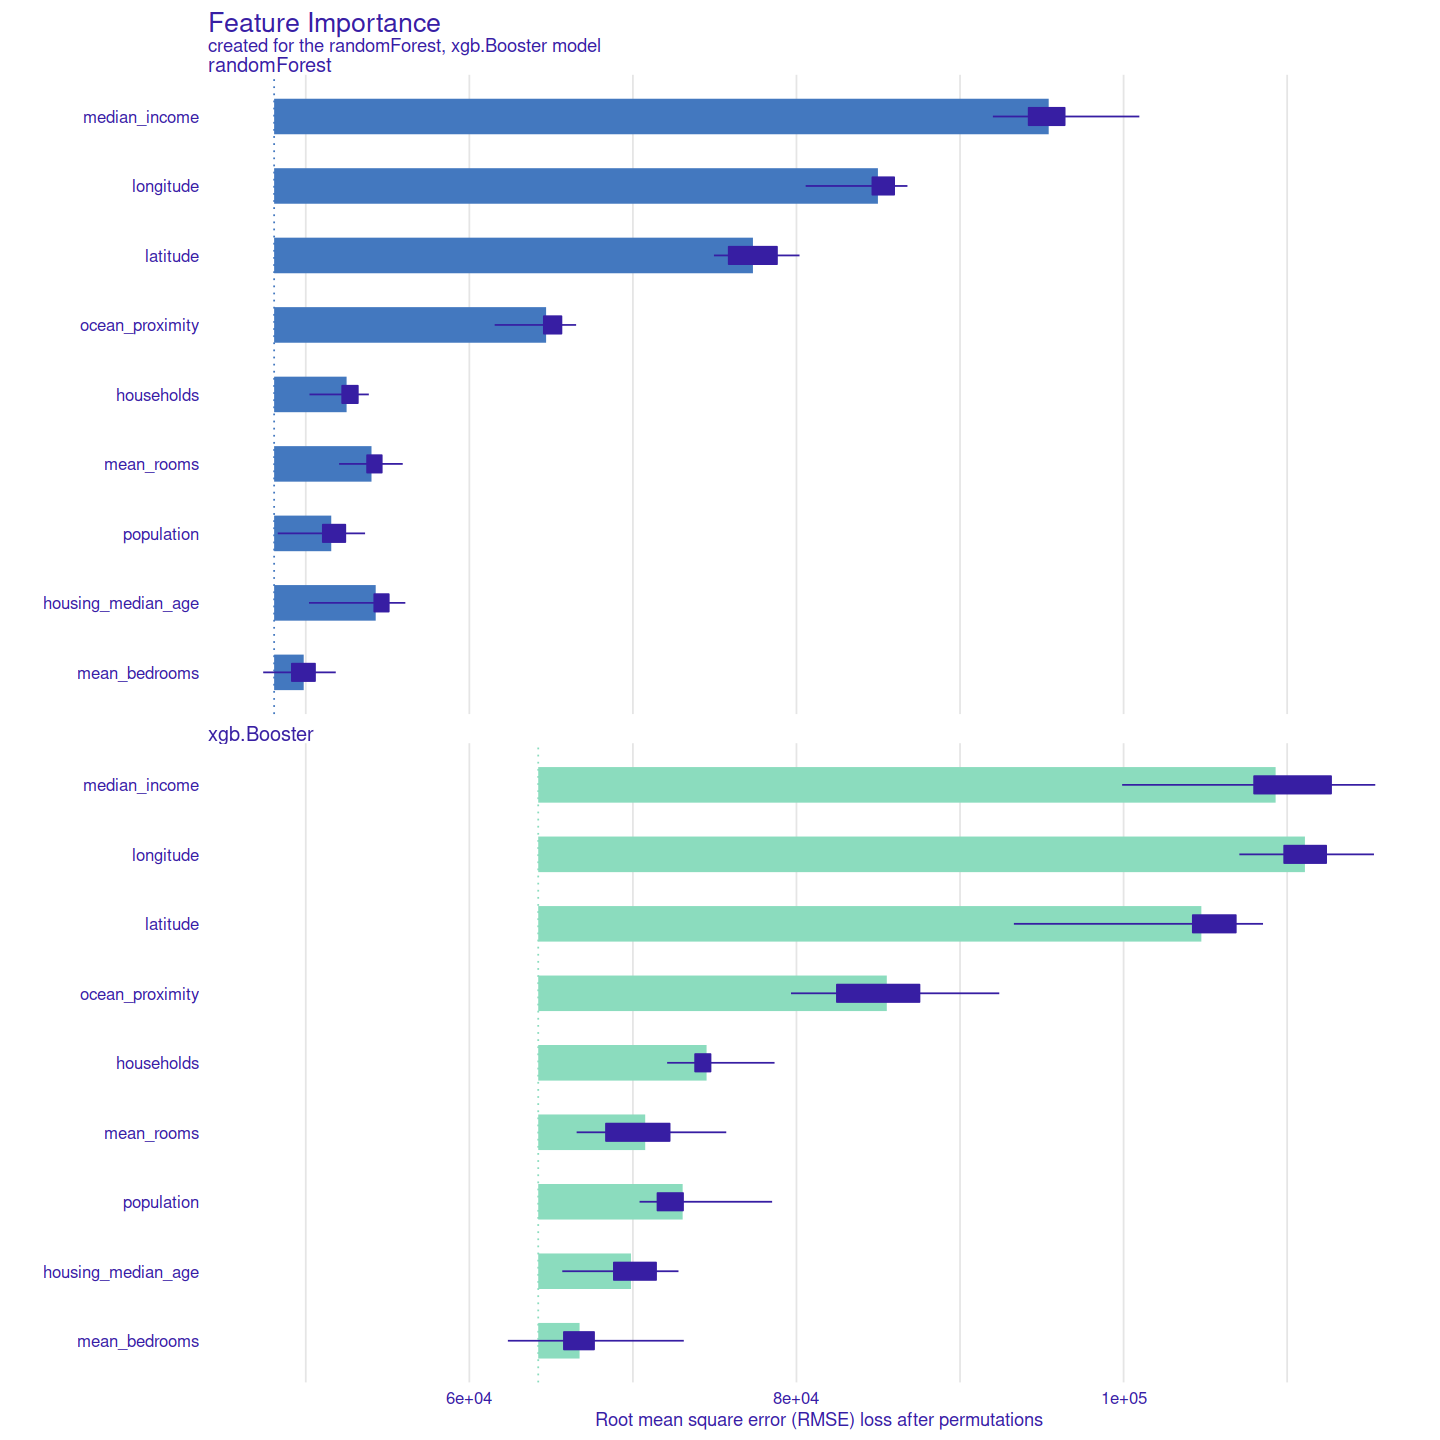

In [152]:
options(repr.plot.width=12, repr.plot.height=12)
plot(fi_1,fi_2)

- model xG jest dużo gorszy
- najważniejsze zmienne są podobne między modelami
- warto zwrócić uwagę, że boxploty w xGboost są znacznie szersze

## Model 3 - ranger

In [17]:
model_ranger <- ranger::ranger(median_house_value~., data = train)

In [173]:
explainer_ranger <- DALEX::explain(model = model_ranger,
                     data = data.matrix(test[,-7]),
                     y = data.matrix(test[,7]))

Preparation of a new explainer is initiated
  -> model label       :  ranger  (  default  )
  -> data              :  4128  rows  9  cols 
  -> target variable   :  4128  values 
  -> predict function  :  yhat.ranger  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package ranger , ver. 0.12.1 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  50074.51 , mean =  207490.9 , max =  499115.9  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -298257.3 , mean =  730.8419 , max =  336699.5  
  A new explainer has been created!  


In [176]:
fi_3 <- model_parts(explainer_ranger, B = 10)

In [244]:
df_rf <- fi_1[(dim(fi_1)[1]-10):(dim(fi_1)[1]-1),c(1,3,4)]
df_rf[,2] <- (df_rf[,2])/df_rf[1,2]
df_rf <- df_rf[-1,]

In [245]:
df_xg <- fi_2[(dim(fi_2)[1]-10):(dim(fi_2)[1]-1),c(1,3,4)]
df_xg[,2] <- (df_xg[,2])/df_xg[1,2]
df_xg <- df_xg[-1,]

In [246]:
df_ranger <- fi_3[(dim(fi_3)[1]-10):(dim(fi_3)[1]-1),c(1,3,4)]
df_ranger[,2] <- (df_ranger[,2])/df_ranger[1,2]
df_ranger <- df_ranger[-1,]

In [247]:
df <- rbind(df_rf, df_xg, df_ranger)

Poniższy barplot pokazuje ile razy wzrasta RMSE po usunięciu informacji z danej kolumny: $\frac{error_{var}}{error_{bas}}$, gdzie:
- $error_{bas}$ - błąd całego modelu
- $error_{var}$ - błąd po usunięciu informacji z kolumny

Dzięki takiej normalizacji możemy porównywać wpływ zmiennych między modelami

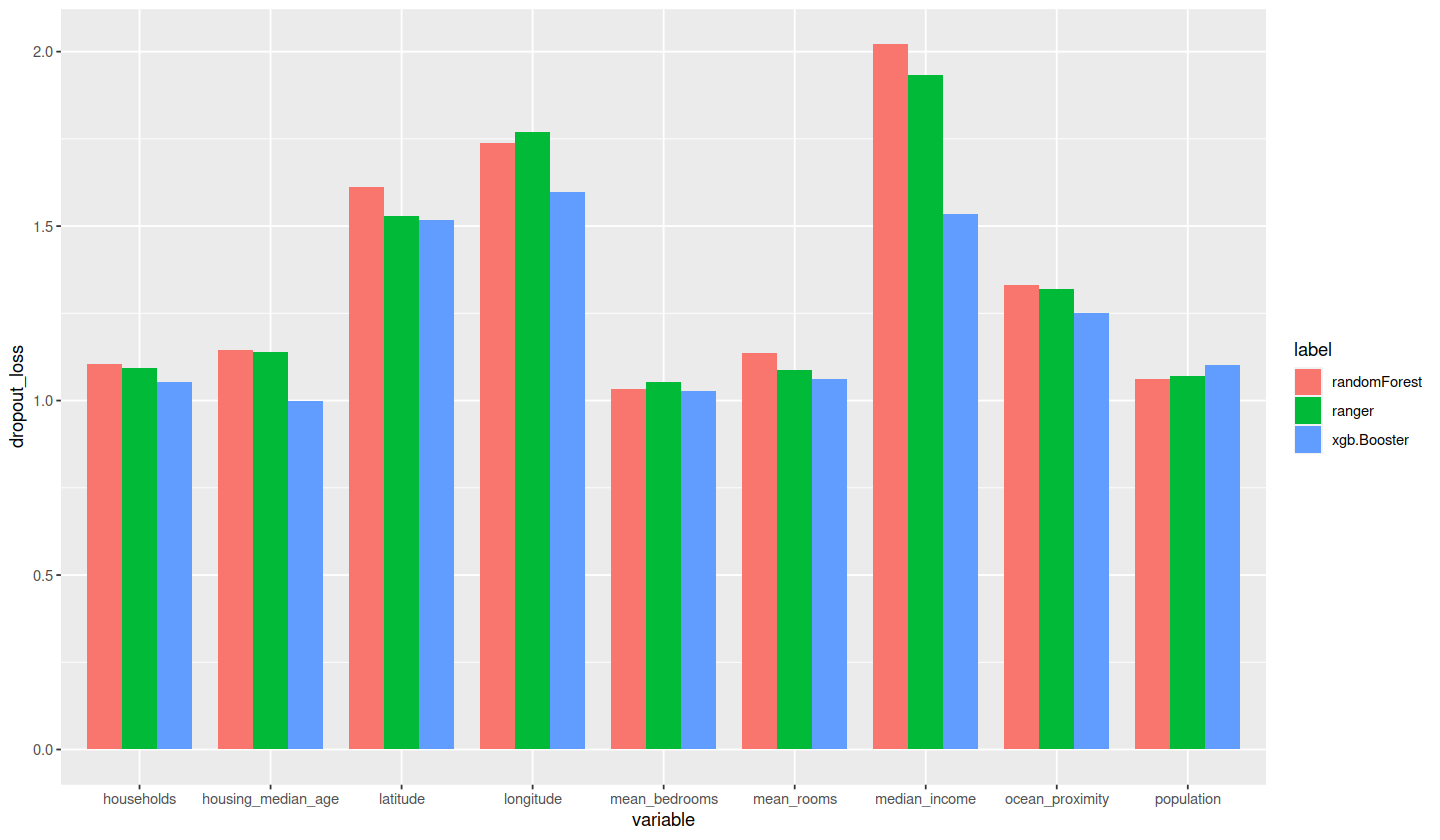

In [248]:
ggplot(df, aes(variable,dropout_loss, fill=label, width=0.8)) +
    geom_bar(stat="identity", position = position_dodge())

Widzimy, że we wszystkich modelach zmienne *households*, *mean_bedrooms* i *population* są praktycznie bezużyteczne. Ciekawe może się wydawać *housing_median_age*, które dla *randomForest*i *rangera* ma wpływ, natomiast dla xGb nie ma wcale. Pozostałe zmienne *latitude*, *longitude*, *median_income* i *ocean_proximity* mają duże wpływy na modele. Warto zauważyć, że największe wpływy te zmienne mają dla *radomForresta*, prawdopodobnie dlatego, że jest on najbardziej efektywnym modelem.